#### **1) Libraries**

In [ ]:
# Don't forget to restart
# !pip install -U tensorflow_probability -q
#!pip install ipdb tensorflow==2.5.0 -q
!pip install ipdb
!pip install git+https://github.com/tensorflow/docs -q
# !pip install -U -i https://test.pypi.org/simple/ nsc -q

    Running setup.py install for tensorflow-docs ... done
  DEPRECATION: tensorflow-docs was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
from IPython import display

import ipdb
import math
import glob
import imageio
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import time
from datetime import datetime
import os
import random
from tqdm import tqdm
from collections import defaultdict

from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.layers import Input, InputLayer, Lambda, Reshape, Dropout, \
                                    Flatten, Dense, Conv2D, Conv2DTranspose

In [ ]:
pip list | grep tensorflow

tensorflow                    2.6.0
tensorflow-datasets           4.0.1
tensorflow-docs               0.0.0f52511c19860e9947261aef83d6b66b6f7a0a3a4-
tensorflow-estimator          2.6.0
tensorflow-gcs-config         2.6.0
tensorflow-hub                0.12.0
tensorflow-metadata           1.2.0
tensorflow-probability        0.13.0


In [ ]:
if tf.test.gpu_device_name() != '/device:GPU:0':
    print('WARNING: GPU device not found.')
else:
    print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

In [ ]:
# List all physical devices
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

If using Google Colab, save in your Google Drive.

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### **2) Extract Data**

In [ ]:
BATCH_SIZE_TRAIN = 256  # 128
BATCH_SIZE_TEST = 5000  # 10000
random_seed = datetime.now().microsecond  # random seed is the microsecond for current time
random_seed = 1234567

# corrupted_names = ['identity', 'motion_blur', 'translate', 'rotate', 'brightness', 'fog', 'shot_noise']
corrupted_names = ['identity', 'motion_blur', 'translate', 'rotate']
datasets_names = ['mnist'] + [f'mnist_corrupted/{corrupted_name}' for corrupted_name in corrupted_names]
# datasets_names = ['mnist', 'mnist_corrupted', 'fashion_mnist', 'cifar10', 'cifar10_corrupted/motion_blur']
datasets_names

['mnist',
 'mnist_corrupted/identity',
 'mnist_corrupted/motion_blur',
 'mnist_corrupted/translate',
 'mnist_corrupted/rotate']

In [ ]:
def _preprocess(sample):
    image = tf.cast(sample['image'], tf.float32) / 255.  # Scale to unit interval.
    return image

def _preprocess_label(sample):
    label = tf.cast(sample['label'], tf.int32)
    return label

In [ ]:
def get_datasets(datasets_names, batch_size_train, batch_size_test):
    datasets = defaultdict(dict)
    for datasets_name in datasets_names:
        print(f"============================================================================================")
        print(f"\nExtracting {datasets_name.upper()} dataset...\n")
        datasets_raw, datasets_raw_info = tfds.load(name=datasets_name,
                                                    with_info=True,
                                                    as_supervised=False
                                                    )
        print(datasets_raw_info)

        # View some examples from the dataset
        fig, axes = plt.subplots(3, 3, figsize=(8, 8))
        fig.subplots_adjust(hspace=0.2, wspace=0.1)
        for i, (elem, ax) in enumerate(zip(datasets_raw['train'], axes.flat)):
            image = tf.squeeze(elem['image'])
            # print(image)
            label = elem['label']

            ax.imshow(image, cmap='gray')
            ax.text(0.7, -0.12, f'Digit = {label}', ha='right',
                    transform=ax.transAxes, color='black')
            ax.set_xticks([])
            ax.set_yticks([])
            # plt.show()

        # Get
        batch_size = batch_size_train if datasets_name == 'mnist' else batch_size_test
        train_size = 60000 if 'mnist' in datasets_name else 50000
        if 'corrupted' not in datasets_name:
            datasets[datasets_name]['train'] = (datasets_raw['train']
                                                .map(_preprocess)
                                                .batch(batch_size)
                                                .prefetch(tf.data.experimental.AUTOTUNE)
                                                .shuffle(train_size)
                                                )
        datasets[datasets_name]['test'] = (datasets_raw['test']
                                           .map(_preprocess)
                                           .batch(batch_size)
                                           .prefetch(tf.data.experimental.AUTOTUNE)
                                           )
        datasets[datasets_name]['test_label'] = (datasets_raw['test']
                                                 .map(_preprocess_label)
                                                 .batch(batch_size)
                                                 .prefetch(tf.data.experimental.AUTOTUNE)
                                                 )

        if 'corrupted' not in datasets_name:
            #
            print(" - Print one train set image:")
            for train_batch in datasets[datasets_name]['train'].take(1):
                image = train_batch[0].numpy()
            image = np.squeeze(image)
            plt.figure()
            plt.imshow(image, cmap='gray')
            plt.colorbar()
            plt.grid(False)
            plt.axis('off')
            plt.show();

        #
        print(" - Print one test set image:")
        for test_batch in datasets[datasets_name]['test'].take(1):
            image = test_batch[0].numpy()
        image = np.squeeze(image)
        plt.figure()
        plt.imshow(image, cmap='gray')
        plt.colorbar()
        plt.grid(False)
        plt.axis('off')
        plt.show();

        #
        print(" - Print one test set label:")
        for test_label in datasets[datasets_name]['test_label'].take(1):
            label = test_label[0]
        print(label.numpy())
        print(f"\n")

    return datasets


Extracting MNIST dataset...

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

 - Print one train set image:


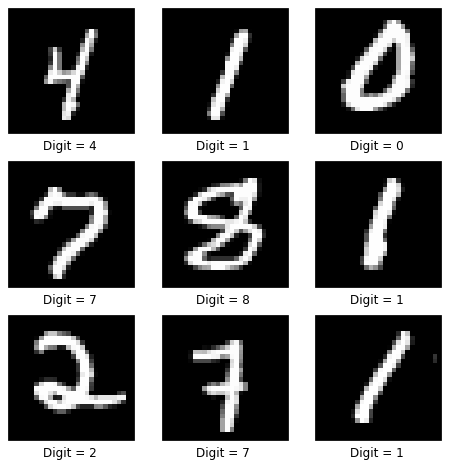

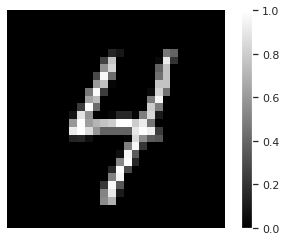

 - Print one test set image:


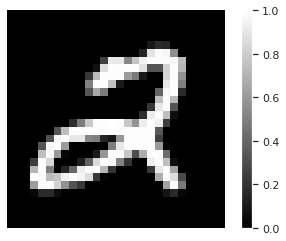

 - Print one test set label:
2



Extracting MNIST_CORRUPTED/IDENTITY dataset...

tfds.core.DatasetInfo(
    name='mnist_corrupted',
    version=1.0.0,
    description='MNISTCorrupted is a dataset generated by adding 15 corruptions to the test
images in the MNIST dataset. This dataset wraps the static, corrupted MNIST
test images uploaded by the original authors',
    homepage='https://github.com/google-research/mnist-c',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{mu2019mnist,
      title={MNIST-C: A Robustness Benchmark for Computer Vision},
      author={Mu, Norman and Gilmer, Justin},
      journal={arXiv preprint arXiv:1906.02337},
      year={2019}
    }""",
    redistribution_info=,
)

 - Print one t

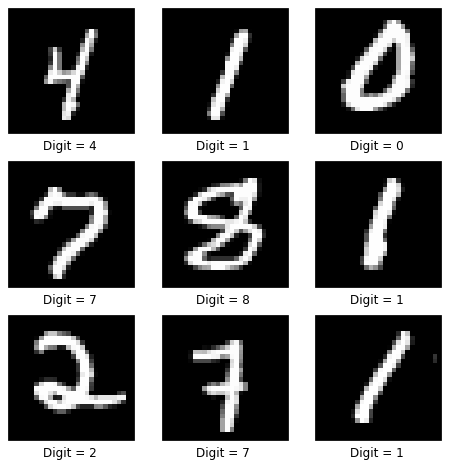

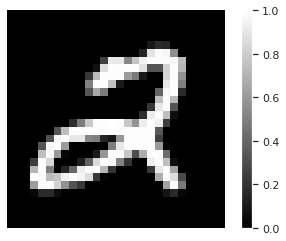

 - Print one test set label:
2



Extracting MNIST_CORRUPTED/MOTION_BLUR dataset...

tfds.core.DatasetInfo(
    name='mnist_corrupted',
    version=1.0.0,
    description='MNISTCorrupted is a dataset generated by adding 15 corruptions to the test
images in the MNIST dataset. This dataset wraps the static, corrupted MNIST
test images uploaded by the original authors',
    homepage='https://github.com/google-research/mnist-c',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{mu2019mnist,
      title={MNIST-C: A Robustness Benchmark for Computer Vision},
      author={Mu, Norman and Gilmer, Justin},
      journal={arXiv preprint arXiv:1906.02337},
      year={2019}
    }""",
    redistribution_info=,
)

 - Print on

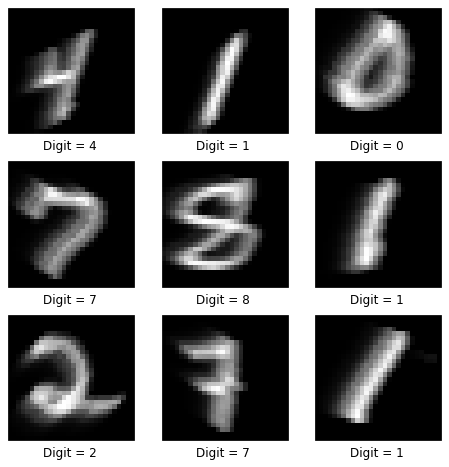

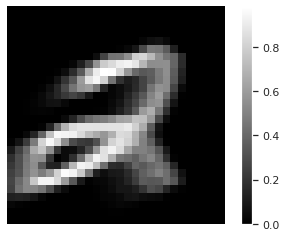

 - Print one test set label:
2



Extracting MNIST_CORRUPTED/TRANSLATE dataset...

tfds.core.DatasetInfo(
    name='mnist_corrupted',
    version=1.0.0,
    description='MNISTCorrupted is a dataset generated by adding 15 corruptions to the test
images in the MNIST dataset. This dataset wraps the static, corrupted MNIST
test images uploaded by the original authors',
    homepage='https://github.com/google-research/mnist-c',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{mu2019mnist,
      title={MNIST-C: A Robustness Benchmark for Computer Vision},
      author={Mu, Norman and Gilmer, Justin},
      journal={arXiv preprint arXiv:1906.02337},
      year={2019}
    }""",
    redistribution_info=,
)

 - Print one 

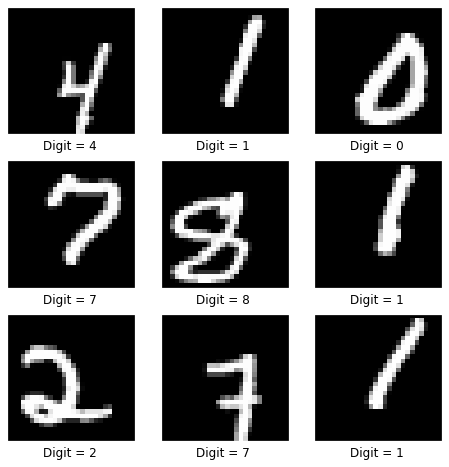

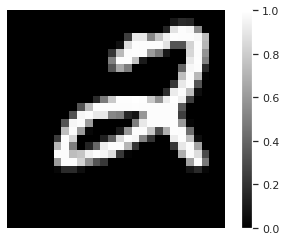

 - Print one test set label:
2



Extracting MNIST_CORRUPTED/ROTATE dataset...

tfds.core.DatasetInfo(
    name='mnist_corrupted',
    version=1.0.0,
    description='MNISTCorrupted is a dataset generated by adding 15 corruptions to the test
images in the MNIST dataset. This dataset wraps the static, corrupted MNIST
test images uploaded by the original authors',
    homepage='https://github.com/google-research/mnist-c',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{mu2019mnist,
      title={MNIST-C: A Robustness Benchmark for Computer Vision},
      author={Mu, Norman and Gilmer, Justin},
      journal={arXiv preprint arXiv:1906.02337},
      year={2019}
    }""",
    redistribution_info=,
)

 - Print one tes

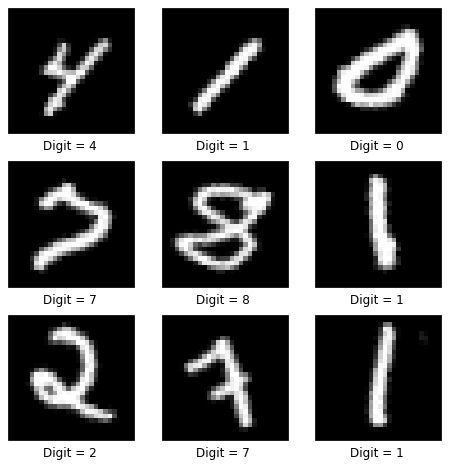

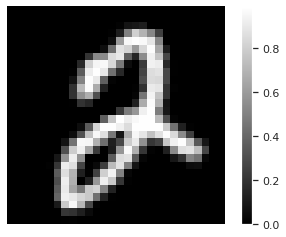

 - Print one test set label:
2


CPU times: user 19.3 s, sys: 8.56 s, total: 27.8 s
Wall time: 11.1 s


In [ ]:
%%time
datasets = get_datasets(datasets_names, BATCH_SIZE_TRAIN, BATCH_SIZE_TEST)

tf.Tensor(0.12891072, shape=(), dtype=float32)

In [ ]:
'''
0	T-shirt/top
1	Trouser
2	Pullover
3	Dress
4	Coat
5	Sandal
6	Shirt
7	Sneaker
8	Bag
9	Ankle boot
'''

'\n0\tT-shirt/top\n1\tTrouser\n2\tPullover\n3\tDress\n4\tCoat\n5\tSandal\n6\tShirt\n7\tSneaker\n8\tBag\n9\tAnkle boot\n'

CIFAR-10 item mapping:

In [ ]:
'''
0	airplane
1	automobile
2	bird
3	cat
4	deer
5	dog
6	frog
7	horse
8	ship
9	truck boot
'''

'\n0\tairplane\n1\tautomobile\n2\tbird\n3\tcat\n4\tdeer\n5\tdog\n6\tfrog\n7\thorse\n8\tship\n9\ttruck boot\n'

#### **3) Model Class**

Credit: https://www.tensorflow.org/api_docs/python/tf/keras/datasets

In [ ]:
!pip install -i https://test.pypi.org/simple/ nsc-tf 

Looking in indexes: https://test.pypi.org/simple/


In [ ]:
from tensorflow.keras import layers as tfkl

import nsc_tf
from math import pi

from tensorflow import repeat, squeeze, reduce_mean, matmul, expand_dims, \
                       transpose, reduce_prod, pow, square, sqrt, cast, \
                       where, zeros_like, int32, float32, equal, reduce_all 
from tensorflow.random import set_seed
from tensorflow.math import log, lgamma, exp, is_finite, reduce_sum, \
                            count_nonzero, add, subtract, multiply, divide
from tensorflow.linalg import det, diag_part, inv, trace

Importing NSC lib v0.0.0.8.


In [ ]:
class Sampler_Z(tfkl.Layer):   

  def call(self, inputs):
    mean, logvar = inputs
    # Reparameterize
    eps = tf.random.normal(shape=mean.shape, seed=0)
    z_sample = eps * tf.exp(logvar * .5) + mean

    #tf.print(tf.math.reduce_mean(eps))

    return z_sample

In [ ]:
# Encoder/Decoder layers 1 (for MNIST images)
class EncoderZ_1(tfkl.Layer):

    def __init__(self, z_dim, n_filter_base, seed, name="encoder", **kwargs):
        super(EncoderZ_1, self).__init__(name=name, **kwargs)
        # Block-1
        self.conv_layer_1 = tfkl.Conv2D(filters=n_filter_base, kernel_size=3,
                                        strides=1, padding='same', name='conv_1'
                                        )

        self.batch_layer_1 = tfkl.BatchNormalization(name='bn_1')
        self.activation_layer_1 = tfkl.Activation(tf.nn.leaky_relu, name='lrelu_1')
        # Block-2
        self.conv_layer_2 = tfkl.Conv2D(filters=n_filter_base*2, kernel_size=3,
                                        strides=2, padding='same', name='conv_2'
                                        )
        self.batch_layer_2 = tfkl.BatchNormalization(name='bn_2')
        self.activation_layer_2 = tfkl.Activation(tf.nn.leaky_relu, name='lrelu_2')
        # Block-3
        self.conv_layer_3 = tfkl.Conv2D(filters=n_filter_base*2, kernel_size=3,
                                        strides=2, padding='same', name='conv_3'
                                        )
        self.batch_layer_3 = tfkl.BatchNormalization(name='bn_3')
        self.activation_layer_3 = tfkl.Activation(tf.nn.leaky_relu, name='lrelu_3')
        # Block-4
        self.conv_layer_4 = tfkl.Conv2D(filters=n_filter_base*2, kernel_size=3,
                                        strides=1, padding='same', name='conv_4'
                                        )
        self.batch_layer_4 = tfkl.BatchNormalization(name='bn_4')
        self.activation_layer_4 = tfkl.Activation(tf.nn.leaky_relu, name='lrelu_4')
        # Final Block
        self.flatten_layer = Flatten()
        self.dense_mean = Dense(z_dim, activation=None, name='z_mean')
        self.dense_raw_stddev = Dense(z_dim, activation=None,
                                      name='z_raw_stddev'
                                      )
        self.sampler_z = Sampler_Z()

    # Functional
    def call(self, x_input):
        z = self.conv_layer_1(x_input)
        z = self.batch_layer_1(z)
        z = self.activation_layer_1(z)
        z = self.conv_layer_2(z)
        z = self.batch_layer_2(z)
        z = self.activation_layer_2(z)
        z = self.conv_layer_3(z)
        z = self.batch_layer_3(z)
        z = self.activation_layer_3(z)
        z = self.conv_layer_4(z)
        z = self.batch_layer_4(z)
        z = self.activation_layer_4(z)
        z = self.flatten_layer(z)
        mean = self.dense_mean(z)
        logvar = self.dense_raw_stddev(z)
        z_sample = self.sampler_z((mean, logvar))
        return z_sample, mean, logvar


class DecoderX_1(tfkl.Layer):

    def __init__(self, z_dim, n_filter_base, name="decoder", **kwargs):
        super(DecoderX_1, self).__init__(name=name, **kwargs)
        # For MNIST images
        self.dense_z_input = tfkl.Dense(units=7*7*n_filter_base*2,
                                        activation=tf.nn.relu
                                        )
        self.reshape_layer = tfkl.Reshape(target_shape=(7, 7, n_filter_base*2))
        # Block-1
        self.conv_transpose_layer_1 = tfkl.Conv2DTranspose(filters=n_filter_base*2,
                                                           kernel_size=3,
                                                           strides=1, 
                                                           padding='same',
                                                           name='conv_transpose_1'
                                                           )
        self.batch_layer_1 = tfkl.BatchNormalization(name='bn_1')
        self.activation_layer_1 = tfkl.Activation(tf.nn.leaky_relu, name='lrelu_1')
        # Block-2
        self.conv_transpose_layer_2 = tfkl.Conv2DTranspose(filters=n_filter_base*2,
                                                           kernel_size=3,
                                                           strides=2, 
                                                           padding='same',
                                                           name='conv_transpose_2'
                                                           )
        self.batch_layer_2 = tfkl.BatchNormalization(name='bn_2')
        self.activation_layer_2 = tfkl.Activation(tf.nn.leaky_relu, name='lrelu_2')
        # Block-3
        self.conv_transpose_layer_3 = tfkl.Conv2DTranspose(filters=n_filter_base,
                                                           kernel_size=3,
                                                           strides=2, 
                                                           padding='same',
                                                           name='conv_transpose_3'
                                                           )
        self.batch_layer_3 = tfkl.BatchNormalization(name='bn_3')
        self.activation_layer_3 = tfkl.Activation(tf.nn.leaky_relu, name='lrelu_3')
        # Block-4
        # Filters=1 for gray-scaled images
        self.conv_transpose_layer_4 = tfkl.Conv2DTranspose(filters=1,
                                                           kernel_size=3,
                                                           strides=1, 
                                                           padding='same',
                                                           name='conv_transpose_4'
                                                           )

    # Functional
    def call(self, z):
        x_output = self.dense_z_input(z)
        x_output = self.reshape_layer(x_output)
        x_output = self.conv_transpose_layer_1(x_output)
        x_output = self.batch_layer_1(x_output)
        x_output = self.activation_layer_1(x_output)
        x_output = self.conv_transpose_layer_2(x_output)
        x_output = self.batch_layer_2(x_output)
        x_output = self.activation_layer_2(x_output)
        x_output = self.conv_transpose_layer_3(x_output)
        x_output = self.batch_layer_3(x_output)
        x_output = self.activation_layer_3(x_output)
        x_output = self.conv_transpose_layer_4(x_output)
        return x_output

In [ ]:
class VAEModel(tfk.Model):
    """Convolutional variational autoencoder base model."""

    def __init__(self, z_dim, n_filter_base, seed):
        super(VAEModel, self).__init__()
        self.encoder = EncoderZ_1(z_dim, n_filter_base, seed)
        self.decoder = DecoderX_1(z_dim, n_filter_base)

    #@tf.function
    def sample(self, z_sample):
        x_recons_logits = self.decoder(z_sample)
        sample_images = tf.sigmoid(x_recons_logits)  # predictions
        return sample_images

    def call(self, x_input):
        z_sample, mean, logvar = self.encoder(x_input)
        x_recons_logits = self.decoder(z_sample)
        return x_recons_logits, z_sample, mean, logvar


In [ ]:
class GeneralizedMean:

    def __init__(self, ll_values, kl_values):
        self.gmean_metrics = pd.Series()
        self.gmean_log_prob_values = {}
        self._save_generalized_mean_metrics('elbo', ll_values - kl_values)
        self._save_generalized_mean_metrics('recon', ll_values)
        self._save_generalized_mean_metrics('kldiv', -kl_values)

    def _save_generalized_mean_metrics(self, key, log_prob_values):
        # Save the generalized means and metric values
        prob_values = tf.exp(log_prob_values)
        self.inv_n = 1 / len(prob_values)  # 1/n
        decisiveness = self._calculate_decisiveness(prob_values)
        accuracy = self._calculate_accuracy(prob_values)
        robustness = self._calculate_robustness(prob_values)
        curr_metrics = pd.Series([decisiveness, accuracy, robustness],
                                 index=[f'{key}_decisiveness', f'{key}_accuracy',
                                        f'{key}_robustness'
                                        ]
                                 )
        self.gmean_metrics = self.gmean_metrics.append(curr_metrics)
        self.gmean_log_prob_values[key] = log_prob_values

    def _calculate_decisiveness(self, values):
        # Decisiveness = Arithmetic mean
        result = tf.reduce_sum(values) * self.inv_n
        return result.numpy()

    def _calculate_accuracy(self, values):
        # Accuracy = Geometric mean
        result = tf.reduce_prod(values ** self.inv_n)
        return result.numpy()

    def _calculate_robustness(self, values):
        # Robustness = -2/3 Mean
        result = tf.reduce_sum(values ** (-2/3))
        result = (result * self.inv_n) ** (-3/2)
        return result.numpy()

    def get_metrics(self):
        return self.gmean_metrics

    def get_log_prob_values(self):
        return self.gmean_log_prob_values

In [ ]:
class Visualize:

    def __init__(self, sample_func, z_sample, sample_labels, gmean_metrics,
                 gmean_log_prob_values, display_path='.'
                 ):
        self.sample_func = sample_func
        self.z_sample = z_sample
        self.sample_labels = sample_labels
        self.gmean_metrics = gmean_metrics
        self.gmean_log_prob_values = gmean_log_prob_values
        self.display_path = display_path
        if len(z_sample) <= 16:
            sample_images = sample_func(z_sample)  # predictions
        else:
            sample_images = sample_func(z_sample)[:16]  # first 16 predictions
        self.sample_images = sample_images
        self.digit_size = len(sample_images[0])

    def display(self, show=True, **kwargs):
        self.display_generated_images(show=show, **kwargs)
        self.display_latent_space(show=show, **kwargs)
        self.display_manifold(show=show, **kwargs)
        self.display_histogram(key='recon', show=show, **kwargs)
        self.display_histogram(key='kldiv', show=show, **kwargs)
        self.display_histogram(key='elbo', show=show, **kwargs)

    def display_generated_images(self, image_size=4, show=True, **kwargs):
        fig = plt.figure(figsize=(image_size, image_size))
        for i in range(self.sample_images.shape[0]):
            plt.subplot(4, 4, i + 1)
            plt.imshow(self.sample_images[i, :, :, 0], cmap='gray')
            plt.axis('off')
        # tight_layout minimizes the overlap between 2 sub-plots
        plt.axis('Off')
        plt.savefig(f"{self.display_path}/generated_images/" + \
                    f"{self._picture_name('images', **kwargs)}"
                    )
        if show:
            plt.show();

    def display_latent_space(self, image_size=4, show=True, **kwargs):
        # display a 2D plot of the digit classes in the latent space
        # Write T-SNE code here:
        # T-SNE ---
        ###
        colors = ['pink', 'red', 'orange', 'yellow', 'green',
                  'blue', 'purple', 'brown', 'gray', 'black'
                  ]
        plt.figure(figsize=(image_size, image_size))
        plt.scatter(self.z_sample[:, 0], self.z_sample[:, 1], c=self.sample_labels,
                    cmap=matplotlib.colors.ListedColormap(colors)
                    )
        plt.colorbar()
        plt.xlabel('z[0]')
        plt.ylabel('z[1]')
        plt.savefig(f"{self.display_path}/latent_spaces/" + \
                    f"{self._picture_name('latent', **kwargs)}"
                    )
        if show:
            plt.show();

    def display_manifold(self, n=20, image_size=10, show=True, **kwargs):
        """Plots n x n digit images decoded from the latent space."""
        norm = tfp.distributions.Normal(0, 1)
        grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
        grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
        image_width = self.digit_size*n
        image_height = image_width
        image = np.zeros((image_height, image_width))
        for i, yi in enumerate(grid_x):
            for j, xi in enumerate(grid_y):
                z = np.array([[xi, yi]])
                x_decoded = self.sample_func(z)
                digit = tf.reshape(x_decoded[0], 
                                   (self.digit_size, self.digit_size)
                                   )
                image[i*self.digit_size: (i+1)*self.digit_size,
                      j*self.digit_size: (j+1)*self.digit_size] = digit.numpy()
        plt.figure(figsize=(image_size, image_size))
        plt.imshow(image, cmap='Greys_r')
        plt.axis('Off')
        plt.savefig(f"{self.display_path}/manifolds/" + \
                    f"{self._picture_name('mani', **kwargs)}"
                    )
        if show:
            plt.show();

    def display_histogram(self, key, image_size=(24, 10), show=True, **kwargs):
        # Get histogram title and x-axis
        if key == 'recon':
            # xlabel = 'Probability of reconstructed image equivalent to original one.'
            xlabel = 'Reconstruction Probability'
            xticks = [1e-240, 1e-210, 1e-180, 1e-150, 1e-120, 1e-90, 1e-60, 1e-30, 1]
        elif key == 'kldiv':
            xlabel = 'Divergence Probability'
            xticks = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
        else:
            xlabel = 'ELBO Probability'
            xticks = [1e-240, 1e-210, 1e-180, 1e-150, 1e-120, 1e-90, 1e-60, 1e-30, 1]
        # Retrieve the generalized means and metric values
        decisiveness = self.gmean_metrics[f'{key}_decisiveness']
        accuracy = self.gmean_metrics[f'{key}_accuracy']
        robustness = self.gmean_metrics[f'{key}_robustness']
        log_prob_values = self.gmean_log_prob_values[key]
        # The histogram of the data
        fig, ax = plt.subplots(figsize=(24, 10))
        xtick_axis = [math.log(xtick) for xtick in xticks]
        xtick_labels = [str(xtick) for xtick in xticks]
        ax.set_xticks(xtick_axis)
        ax.set_xticklabels(xtick_labels)
        plt.title(f"{xlabel} Histogram for VAE (Epoch={kwargs['epoch']})", fontdict = {'fontsize' : 40, 'weight': 'bold'})
        plt.xlabel(xlabel, fontdict = {'fontsize' : 40, 'weight': 'bold'})
        plt.ylabel("Frequency in logscale", fontdict = {'fontsize' : 40, 'weight': 'bold'})
        # Plot in logscale, so convert the metric as logs as well
        log_dec, log_acc, log_rob = np.log(decisiveness), np.log(accuracy), np.log(robustness)
        dec_txt, acc_txt, rob_txt = f'{decisiveness:0.2e}', f'{accuracy:0.2e}', f'{robustness:0.2e}'
        plt.axvline(log_dec, color='g', linestyle='dashed', linewidth=2)
        plt.text(log_dec, 10*12, dec_txt, color='g', size='large', weight='bold')
        plt.axvline(log_acc, color='b', linestyle='dashed', linewidth=2)
        plt.text(log_acc, 10*12, acc_txt, color='b', size='large', weight='bold')
        plt.axvline(log_rob, color='r', linestyle='dashed', linewidth=2)
        plt.text(log_rob, 10*12, rob_txt, color='r', size='large', weight='bold')
        plt.hist(log_prob_values, log=True, bins=100, facecolor='white', edgecolor='black')
        plt.savefig(f"{self.display_path}/histograms/{key}/" + \
                    f"{self._picture_name(f'hist_{key}', **kwargs)}"
                    )
        if show:
            plt.show();

    def _picture_name(self, display_type, **kwargs):
        name = display_type
        for key, value in kwargs.items():
            name += f'_{key}{str(value)}'
        return f'{name}.png'

In [ ]:
class VAE:
    """Variational Autoencoder wrapper."""
    def __init__(self, z_dim, n_filter_base=32, learning_rate=0.0005,
                 beta=1., p_std=1., seed=0, loss_coupling = 0.0,
                 analytic_kl=False, display_path='.'
                 ):
        self.optimizer = tfk.optimizers.Adam(learning_rate)
        self.model = VAEModel(z_dim, n_filter_base, seed)
        metrics_col = ['epoch', 'neg_elbo', 'recon_loss', 'kl_div'] + \
                      [f'{x}_{y}' for x in ['elbo', 'recon', 'kl'] 
                                  for y in ['decisiveness', 'accuracy', 'robustness']
                       ]
        self.metrics_df = pd.DataFrame(columns=metrics_col)
        self.beta = beta
        self.p_std = p_std
        self.analytic_kl = analytic_kl
        self.display_path = display_path
        self._set_random_seeds(seed)
        self.loss_coupling = loss_coupling

    def train(self, train_dataset, test_dataset, test_label, n_epoch=10,
              n_epoch_display=10
              ):
        # Pick a sample of the test set for generating output images
        for test_batch, test_batch_label in zip(test_dataset.take(1),
                                                test_label.take(1)
                                                ):
            test_sample = test_batch
            test_sample_label = test_batch_label
        
        

        for epoch in range(1, n_epoch + 1):
            start_time = time.time()
            for train_x in tqdm(train_dataset):
                self.train_step(train_x)
            end_time = time.time()
            # Get Loss Metrics
            for test_x in test_dataset:
                loss, neg_ll, kl_div, ll_values, kl_values = self.compute_loss(test_x)
            display.clear_output(wait=False)
            print(f"Epoch: {epoch}, Test set Loss: {loss}, " + \
                  f"Test set Recon: {neg_ll}, Test set KL: {kl_div}, " + \
                  f"time elapse for current epoch: {end_time - start_time}"
                  )
            
            ipdb.set_trace()
            # Generalized Mean
            gmean = GeneralizedMean(ll_values, kl_values)
            # Visualize / Display
            display_list = [1, 2, 3, 5, 15]
            if epoch in display_list or epoch % n_epoch_display == 0:
                z_sample, _, _ = self.model.encoder(test_sample)
                viz = Visualize(self.model.sample,
                                z_sample,
                                test_sample_label,
                                gmean.get_metrics(),
                                gmean.get_log_prob_values(),
                                self.display_path
                                )
                viz.display(cd='X',
                            cl='X',
                            epoch=epoch
                            )
            metrics_row = [int(epoch), loss.numpy(), neg_ll.numpy(), kl_div.numpy()]
            metrics_row = pd.Series(metrics_row, index=self.metrics_df.columns[:4])
            metrics_row = metrics_row.append(gmean.get_metrics())
            self.metrics_df = self.metrics_df.append(metrics_row, ignore_index=True)

    # @tf.function
    def train_step(self, x_true):
        """Executes one training step and returns the loss.

        This function computes the loss and gradients, and uses the latter to
        update the model's parameters.
        """
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x_true, True)
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

    def log_normal_pdf(self, sample, mean, logvar, raxis=1):
        log2pi = tf.math.log(2. * np.pi)
        return tf.reduce_sum(
            -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
            axis=raxis)
    
    def coupled_kl_divergence_vs_standard_mvn_analytical(self, loc, scale, kappa):
        """
        This function calculates the coupled divergence between the input 
        distribution and the multivariate Gaussian centered at the origin whose
        covariance matrix is the identity matrix.
        Parameters
        ----------
        loc : tf.Tensor
        scale : tf.Tensor
        kappa : float
            The coupling of the divergence function.
        Returns
        -------
        coupted_divergence : tf.Tensor
            The coupled divergence between an input distribution and the standard
            multivariate Gaussian.
        """

        loc_q = loc
        scale_q = diag_part(scale)
        dim = loc.shape[-1]

        d1 = 1 + dim*kappa + 2*kappa  

        coupled_div_t1 = add(
            multiply(kappa, nsc_tf.math.function.coupled_logarithm(2*pi, kappa=kappa, dim=dim)), 1
            )
        coupled_div_t1 = multiply(
            coupled_div_t1, 
            sqrt(divide(d1, (subtract(d1, multiply(2*kappa, square(scale_q))))))
            )
        #ipdb.set_trace()
        coupled_div_t1 *= exp(
            divide(multiply(multiply(square(loc_q), d1), kappa), 
                  multiply((1 + dim*kappa), 
                            (subtract(d1, 2*kappa*square(scale_q)))))
            )
        coupled_div_t1 = reduce_prod(coupled_div_t1, axis=1)

        coupled_div_t2 = multiply(kappa, 
                                  nsc_tf.math.function.coupled_logarithm(
                                      multiply(2*pi, square(scale_q)), 
                                      kappa=kappa, 
                                      dim=dim)
                                  )
        coupled_div_t2 = add(coupled_div_t2, 1)
        coupled_div_t2 *= sqrt(d1 / (1 + dim*kappa))
        coupled_div_t2 = reduce_prod(coupled_div_t2, axis=1)

        coupled_divergence = subtract(coupled_div_t1, coupled_div_t2) 
        coupled_divergence = divide(coupled_divergence, 2*kappa)

        return coupled_divergence

    def compute_loss(self, x_true, train=False):
        x_recons_logits, z_sample, mean, logvar = self.model(x_true)


        if self.loss_coupling == 0.0:
          # Sigmoid Cross Entropy Loss
          cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_recons_logits,
                                                              labels=x_true
                                                              )
          # Negative Log-Likelihood
          logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])  # log-likelihood
          neg_ll = -logpx_z  # negative log-likelihood
          # KL-Divergence
          if self.analytic_kl == True:
              sd = tf.math.log(1 + tf.math.exp(logvar))
              kl_div = -0.5 * tf.math.reduce_sum(1 + tf.math.log(tf.math.square(sd)) - \
                                                tf.math.square(mean) - \
                                                tf.math.square(sd),
                                                axis=1
                                                )
          else:
              logpz = self.log_normal_pdf(z_sample, 0., self.p_std)
              logqz_x = self.log_normal_pdf(z_sample, mean, logvar)
              kl_div = logqz_x - logpz
          # ELBO
          neg_ll_mean = tf.math.reduce_mean(neg_ll)
          kl_div_mean = tf.math.reduce_mean(kl_div)
          # elbo = -self.beta*kl_div_mean + neg_ll_mean
          loss = neg_ll_mean + self.beta*kl_div_mean

        else:
          ##NSC ELBO

          #Conversion from logits to probs
          p = x_true
          q = tf.math.sigmoid(x_recons_logits)

          #Calculation of binary log_loss
          cross_ent_2 = p*nsc_tf.math.function.coupled_logarithm(q, kappa=self.loss_coupling) + (1-p)*nsc_tf.math.function.coupled_logarithm(1-q, kappa=self.loss_coupling)

          logpx_z= tf.reduce_sum(cross_ent_2, axis=[1, 2, 3])
          neg_ll = -logpx_z

          kl_div = self.coupled_kl_divergence_vs_standard_mvn_analytical(loc=mean, scale=tf.linalg.diag(tf.exp(logvar/2)), kappa=self.loss_coupling)

          neg_ll_mean = tf.math.reduce_mean(neg_ll)
          kl_div_mean = tf.math.reduce_mean(kl_div)

          loss = neg_ll_mean + self.beta*kl_div_mean


        if train:
            return loss
        return loss, neg_ll_mean, kl_div_mean, \
               tf.cast(logpx_z, tf.float64), tf.cast(kl_div, tf.float64)

    def _set_random_seeds(self, seed):
        tf.random.set_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

#### **4) Models Train**

In [ ]:
datasets['mnist']['train'], datasets['mnist']['test']

(<ShuffleDataset shapes: (None, 28, 28, 1), types: tf.float32>,
 <PrefetchDataset shapes: (None, 28, 28, 1), types: tf.float32>)

In [ ]:
datasets['mnist_corrupted/motion_blur']['test']

<PrefetchDataset shapes: (None, 28, 28, 1), types: tf.float32>

In [ ]:
# datasets['cifar10']['train'], datasets['cifar10']['test']

In [ ]:
# SET HYPERPARAMETERS HERE ####################################################

# vae init params
z_dim = 2  # latent dim, set the dimensionality of the latent space to a plane for visualization later
n_filter_base = 32  # number of base filters in the CNN (a lot of filters?)
learning_rate = 0.0005  # uses for the internal Adam opt
# vae train params
n_epoch = 10  # 100 number of epochs
n_epoch_display = 5  # 10 number of epochs before displaying plots
show_display = True
display_sample = False

analytic_kl = True
beta = 1.
p_std = 1.

version = 'v4.3'
save_path = f'gdrive/My Drive/Colab Notebooks/coupled_vae/vae/output/{version}/'

print(f"Your current randomly generated seed is {random_seed}. DON'T LOSE TRACK OF YOUR SEEDS!")

Your current randomly generated seed is 1234567. DON'T LOSE TRACK OF YOUR SEEDS!


In [ ]:
def create_gdrive_output_folders(save_path, seed):
    if not os.path.isdir(save_path):
        os.mkdir(save_path)

    seed_path = f'{save_path}seed{seed}/'
    if os.path.isdir(seed_path):
        return
    os.mkdir(seed_path)

    img_folders = ['identity', 'motion_blur', 'rotate', 'translate']
    viz_folders = ['generated_images', 'latent_spaces', 'manifolds', 
                   'histograms', 'metrics'
                   ]

    for img_folder in img_folders:
        img_path = f'{seed_path}{img_folder}/'
        os.mkdir(img_path)

        for viz_folder in viz_folders:
            viz_path = f'{img_path}{viz_folder}/'
            os.mkdir(viz_path)

            if viz_folder == 'histograms':
                os.mkdir(f'{viz_path}elbo/')
                os.mkdir(f'{viz_path}recon/')
                os.mkdir(f'{viz_path}kldiv/')

create_gdrive_output_folders(save_path, random_seed)  # Will not override existing version and seed folders

In [ ]:
vae_list = {}

save_path += f'seed{random_seed}/'
print(save_path)

gdrive/My Drive/Colab Notebooks/coupled_vae/vae/output/v4.3/seed1234567/


In [ ]:
%%time
from tensorflow.python.framework import ops

for test_name in datasets_names[1:]:  # excluding 'mnist', only 'mnist_corrupted/*'
    # display_name = 'original' if test_name == 'mnist' else test_name.split('/')[-1]
    display_name = test_name.split('/')[-1]
    display_path = save_path + display_name
    vae_list[display_name] = VAE(z_dim=z_dim,
                                 beta=beta,
                                 p_std=p_std,
                                 seed=249839,
                                 loss_coupling=0.001,
                                 analytic_kl=analytic_kl,
                                 display_path=display_path
                                 )
    vae_list[display_name].train(train_dataset=datasets['mnist']['train'],
                                 test_dataset=datasets[test_name]['test'],
                                 test_label=datasets[test_name]['test_label'],
                                 n_epoch=n_epoch,
                                 n_epoch_display=n_epoch_display,
                                 )
    # Save to metrics tables.csv
    vae_list[display_name].metrics_df.to_csv(f"{display_path}/metrics/table.csv",
                                             index=False
                                             )


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.7/bdb.py", line 332, in set_trace
    sys.settrace(self.trace_dispatch)



Epoch: 1, Test set Loss: 179.5227508544922, Test set Recon: 175.44725036621094, Test set KL: 4.075504779815674, time elapse for current epoch: 125.84185194969177
> <ipython-input-20-92d2770a21b4>(49)train()
     48             # Generalized Mean
---> 49             gmean = GeneralizedMean(ll_values, kl_values)
     50             # Visualize / Display

ipdb> q



PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.7/bdb.py", line 357, in set_quit
    sys.settrace(None)



BdbQuit: ignored

Epoch: 1, Test set Loss: 179.53759765625, Test set Recon: 175.3159942626953, Test set KL: 4.221596717834473, time elapse for current epoch: 141.9227032661438

In [ ]:
vae_list.keys()

dict_keys(['identity'])

#### **5) Models Display**

Use vanilla VAE model with prior std = 1 as example

In [ ]:
vae = vae_list['identity']

In [ ]:
# def display_image(epoch_no):
#     return PIL.Image.open(f"{display_path}/generated_images/{_picture_name('images', epoch=epoch_no)}")
#     # return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
# plt.imshow(display_image(n_epoch))
# plt.axis('off')  # Display images

In [ ]:
# anim_file = 'cvae.gif'

# with imageio.get_writer(anim_file, mode='I') as writer:
#     filenames = glob.glob('image*.png')
#     filenames = sorted(filenames)
#     for filename in filenames:
#         image = imageio.imread(filename)
#         writer.append_data(image)
#     image = imageio.imread(filename)
#     writer.append_data(image)

In [ ]:
# import tensorflow_docs.vis.embed as embed
# embed.embed_file(anim_file)

In [ ]:
def plot_latent_images(model, n, digit_size=28):
    """Plots n x n digit images decoded from the latent space."""
    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
    image_width = digit_size*n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi]])
            x_decoded = model.sample(z)
            digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
            image[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit.numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show();

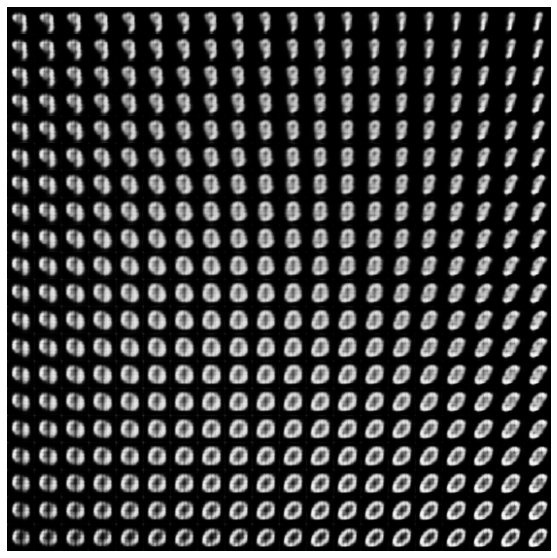

In [ ]:
plot_latent_images(vae.model, 20)

Summarize history for loss

In [ ]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [ ]:
x = range(1, n_epoch + 1)

ValueError: ignored

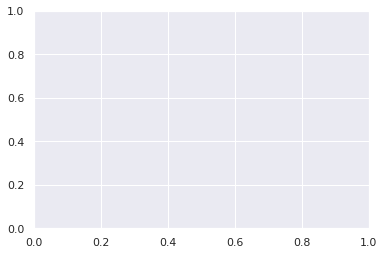

In [ ]:
for key, vae in vae_list.items():
    y = vae.metrics_df['neg_elbo']
    plt.plot(x, y, label=key)
plt.title('VAE Total Loss vs Epoch')
plt.ylabel('Total Loss (negELBO)')
plt.xlabel('Epoch')
# plt.ylim(ymin=0)
plt.legend(title='MNIST type')
plt.rcParams["figure.figsize"] = (16, 10)
plt.show();

In [ ]:
for key, vae in vae_list.items():
    y = vae.metrics_df['recon_loss']
    plt.plot(x, y, label=key)
plt.title('VAE Reconstruction Loss vs Epoch')
plt.ylabel('Reconstruction Loss (NLL)')
plt.xlabel('Epoch')
# plt.ylim(ymin=0)
plt.legend(title='beta')
plt.rcParams["figure.figsize"] = (16, 10)
plt.show();

In [ ]:
for key, vae in vae_list.items():
    y = vae.metrics_df['kl_div']
    plt.plot(x, y, label=key)
plt.title('VAE KL-Divergence vs Epoch')
plt.ylabel('KL-Divergence')
plt.xlabel('Epoch')
# plt.ylim(ymin=0)
plt.legend(title='beta')
plt.rcParams["figure.figsize"] = (16, 10)
plt.show();